In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install allennlp-models
!pip install allennlp

In [3]:
from typing import Dict, Iterable, List

import torch
import pandas as pd
from allennlp.data import DatasetReader, Instance, Vocabulary, TextFieldTensors
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, TokenCharactersIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WhitespaceTokenizer, CharacterTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, TokenCharactersEncoder
from allennlp.modules.seq2vec_encoders import LstmSeq2VecEncoder, CnnEncoder
from allennlp.nn import util
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.data.data_loaders import MultiProcessDataLoader, DataLoader


In [4]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from typing import Dict
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True,
        save_dir='results'):
    """
        Vẽ confusion matrix
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    width = int(10/7*len(target_names))

    height = int(8/7*len(target_names))

    # plt.figure(figsize=(width, height))
    plt.imshow(cm, cmap=cmap)
    # plt.title(title)
    plt.colorbar()

    if target_names:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if os.path.exists(save_dir) is False:
        os.mkdir(save_dir)

    try:
        print(f"Save confusion-matrix...")
        plt.savefig((save_dir + '/{}.png'.format(title)))
    except IOError:
        print(f"Could not save file in directory: {save_dir}")

    plt.show()

In [5]:
def predict(model, text: str, max_tokens, token_indexers):
    tokens = [Token(token) for token in text.split(' ')]
    
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]

    text_field = TextField(tokens, token_indexers)
    instance = Instance({
        "tokens": text_field
    })
    output = model.forward_on_instance(instance)
    y_prediction = np.argmax(output['probs'], axis=-1)
    y_probs = np.max(output['probs'], axis=-1)
    prediction = model.vocab.get_token_from_index(y_prediction, namespace='labels')
    return prediction

In [6]:
def predict_on_df(model, data_reader, data_df, label_col='sentiment'):
    vocab = model.vocab
    max_tokens = data_reader.max_tokens
    token_indexers = data_reader.token_indexers
    texts = data_df['text'].tolist()
    label_pred = [predict(model, text, max_tokens, token_indexers) for text in texts]
    data_df[f'{label_col}_pred'] = label_pred
    return data_df

In [7]:
def eval_model(model, data_reader, test_df, plot_cm=False):
    vocab = model.vocab
    max_tokens = data_reader.max_tokens
    token_indexers = data_reader.token_indexers
    test_df = pd.read_csv(test_path)
    texts = test_df['text'].tolist()
    label_true = test_df['sentiment'].tolist()
    label_pred = [predict(model, text, max_tokens, token_indexers) for text in texts]
    y_true = [vocab.get_token_index(label, namespace='labels') for label in label_true]
    y_pred = [vocab.get_token_index(label, namespace='labels') for label in label_pred]

    # get metric scores
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    labels = list(vocab.get_token_to_index_vocabulary('labels').keys())
    report = classification_report(label_true, label_pred, labels=labels)
    print(f'Evaluate ')
    print('Accuracy :', acc)
    print('Precision:', precision)
    print('Recall   :', recall)
    print('F1-Score :', f1)
    if plot_cm:
        cm = confusion_matrix(label_true, label_pred, labels=labels)
        plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix (sentiment)', normalize=False)
        plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix Normalize (sentiment)', normalize=True)
    return acc, precision, recall, f1

In [8]:
class SentimentDataReader(DatasetReader):
    def __init__(
        self,
        tokenizer: Tokenizer = None,
        char_tokenizer: CharacterTokenizer = None,
        token_indexers: Dict[str, TokenIndexer] = None,
        use_character: bool = True,
        max_tokens: int = None,
        label_col: str = 'sentiment',
        **kwargs
    ):
        super().__init__(**kwargs)
        self.tokenizer = tokenizer or WhitespaceTokenizer()
        self.char_tokenizer = char_tokenizer or CharacterTokenizer()
        if token_indexers is None:
            if use_character:
                self.token_indexers = {
                        "tokens": SingleIdTokenIndexer(namespace="tokens"),
                        "token_characters": TokenCharactersIndexer(namespace="token_characters", min_padding_length=3)
                    }
            else:
                self.token_indexers = {
                        "tokens": SingleIdTokenIndexer(namespace="tokens") 
                         }
        else:
            self.token_indexers = token_indexers
        self.max_tokens = max_tokens
        self.label_col = label_col

    def text_to_instance(self, text, label=None):
        tokens = self.tokenizer.tokenize(text)
        if self.max_tokens:
                tokens = tokens[: self.max_tokens]

        text_field = TextField(tokens, self.token_indexers)
        fields = {
            "tokens": text_field
        }
        if label:
            fields['label'] = LabelField(label)
        return Instance(fields)

    def _read(self, file_path) -> Iterable[Instance]:
        if isinstance(file_path, str):
            df = pd.read_csv(file_path)
        elif isinstance(file_path, pd.DataFrame):
            df = file_path
        for _, row in df.iterrows():
            text = row['text']
            sentiment = row[self.label_col]
            yield self.text_to_instance(text, sentiment)


In [9]:
instances = SentimentDataReader(use_character=False).read('/content/drive/MyDrive/Learning/20202/NLP/data/val.csv')
c = 0
for i in instances:
  print(i)
  c+=1
  if c> 2:
    break

Instance with fields:
 	 tokens: TextField of length 6 with text: 
 		[giáo, trình, chưa, cụ, thể, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 4 with text: 
 		[giảng, buồn, ngủ, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 8 with text: 
 		[giáo, viên, vui, tính, ,, tận, tâm, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: positive in namespace: 'labels'. 



In [10]:
df = pd.read_csv('/content/drive/MyDrive/Learning/20202/NLP/data/val.csv')
instances = SentimentDataReader(use_character=False).read(df)
c = 0
for i in instances:
  print(i)
  c+=1
  if c> 2:
    break

Instance with fields:
 	 tokens: TextField of length 6 with text: 
 		[giáo, trình, chưa, cụ, thể, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 4 with text: 
 		[giảng, buồn, ngủ, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: negative in namespace: 'labels'. 

Instance with fields:
 	 tokens: TextField of length 8 with text: 
 		[giáo, viên, vui, tính, ,, tận, tâm, .]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 label: LabelField with label: positive in namespace: 'labels'. 



In [22]:
from allennlp.training.metrics import CategoricalAccuracy, F1Measure
from allennlp.modules.attention.attention import Attention
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder, Seq2SeqEncoder
from allennlp.modules.attention.linear_attention import LinearAttention
from allennlp.modules.attention.dot_product_attention import DotProductAttention
from allennlp.modules.attention.bilinear_attention import BilinearAttention
from allennlp.modules.attention.additive_attention import AdditiveAttention


class SimpleClassifier(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2SeqEncoder,
                 dropout=0.4
        ):
        super().__init__(vocab)
        self.embedder = embedder
        self.encoder = encoder
        self.bidirectional = self.encoder.is_bidirectional()
        if self.bidirectional:
            self.hidden_size = int(self.encoder.get_output_dim()/2)
        else:
            self.hidden_size = self.encoder.get_output_dim()
        self.num_labels = vocab.get_vocab_size("labels")
        self.attention_layer = AdditiveAttention(vector_dim=encoder.get_output_dim(), 
                                                 matrix_dim=encoder.get_output_dim(),
                                                 normalize=True)
        self.project_layer = torch.nn.Linear(self.encoder.get_output_dim()*2, self.encoder.get_output_dim())
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(self.encoder.get_output_dim()*2, self.num_labels)
        self.accuracy = CategoricalAccuracy()
        
        init_weight(self)
        
        self.f1_measure = F1Measure(1)
    
    def init_weight(self):
        torch.nn.init.xavier_normal_(self.project_layer.weight)
        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(tokens)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(tokens)

        # Shape: (batch_size, encoding_dim) if use seq2vec
        # Shape: (batch_size, seq_len, encoding_dim) if use seq2seq
        encoded_text = self.encoder(embedded_text, mask)
        if self.bidirectional:
            last_forward = encoded_text[:, -1, :self.hidden_size]
            first_backward = encoded_text[:, 0, self.hidden_size:]
            context_vector = torch.cat([last_forward, first_backward], dim=-1)
        else:
            context_vector = encoded_text[:, -1, :]
        
        # Shape: (batch_size, seq_len)
        att_weight = self.attention_layer(context_vector, encoded_text)

        # Shape: (batch_size, hidden_size)
        att_hidden = torch.bmm(encoded_text.transpose(-2, -1), att_weight.unsqueeze(-1)).squeeze(-1)
        context_att = torch.cat([context_vector, att_hidden], dim=-1)
        logits = self.classifier(context_att)
        # Shape: (batch_size, num_labels)
        probs = torch.nn.functional.softmax(logits)
        # Shape: (1,)
        output = {
            'probs': probs,
            'logits': logits
        }
        if label is not None:
            loss = torch.nn.functional.cross_entropy(logits, label)
            output['loss'] = loss
            self.accuracy(logits, label)
            self.f1_measure(logits, label)

        return output
    
    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        metrics_result = self.f1_measure.get_metric(reset)
        metrics_result['accuracy'] = self.accuracy.get_metric(reset)
        
        return metrics_result

In [23]:
import tempfile
from typing import Dict, Iterable, List, Tuple
import shutil
import os

import allennlp
import torch
from allennlp.data import (
    DataLoader,
    DatasetReader,
    Instance,
    Vocabulary,
    TextFieldTensors,
)
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WhitespaceTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder, Seq2SeqEncoder
from allennlp.modules.seq2vec_encoders import BagOfEmbeddingsEncoder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.nn import util
from allennlp.training.trainer import GradientDescentTrainer, Trainer
from allennlp.training.optimizers import AdamOptimizer
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.modules.seq2seq_encoders import LstmSeq2SeqEncoder



train_path = '/content/drive/MyDrive/Learning/20202/NLP/data/train.csv'
test_path = '/content/drive/MyDrive/Learning/20202/NLP/data/test.csv'
val_path = '/content/drive/MyDrive/Learning/20202/NLP/data/val.csv'

def build_model(
    vocab,
    embedding_dim=100,
    hidden_size=128,
    char_embedding_dim=34,
    dropout=0.4,
    bidirectional=True,
    use_character=True,
    word_embedding_pretrain_file=None
):
     # token embedding
    embedding = Embedding(embedding_dim=embedding_dim, vocab_namespace='tokens', vocab=vocab, pretrained_file=word_embedding_pretrain_file)
        
    # char embedding with cnnencoder
    character_embedding = Embedding(embedding_dim=char_embedding_dim, vocab_namespace='token_characters', vocab=vocab)
    cnn_encoder = CnnEncoder(embedding_dim=char_embedding_dim, num_filters=char_embedding_dim, ngram_filter_sizes=(3,))
    token_encoder = TokenCharactersEncoder(character_embedding, cnn_encoder)

    if use_character:
        embedder = BasicTextFieldEmbedder(
            {
                "tokens": embedding,
                "token_characters": token_encoder
            }
        )
    else:
        embedder = BasicTextFieldEmbedder(
            {
                "tokens": embedding            
             }
        )
        
    encoder = LstmSeq2SeqEncoder(input_size=embedder.get_output_dim(), hidden_size=hidden_size, num_layers=2, bidirectional=bidirectional, dropout=dropout)

    model = SimpleClassifier(
        vocab,
        embedder,
        encoder
    )
    model.to('cuda')
    return model

def build_dataset_reader(max_tokens=80, label_col='sentiment', use_character=True) -> DatasetReader:
    return SentimentDataReader(max_tokens=max_tokens, label_col=label_col, use_character=use_character)


def read_data(reader: DatasetReader, train_path, val_path) -> Tuple[List[Instance], List[Instance]]:
    print("Reading data")
    training_data = list(reader.read(train_path))
    validation_data = list(reader.read(val_path))
    return training_data, validation_data


def build_vocab(instances: Iterable[Instance]) -> Vocabulary:
    print("Building the vocabulary")
    return Vocabulary.from_instances(instances)

def build_data_loaders(
    train_data: List[Instance],
    dev_data: List[Instance],
    batch_size=64
) -> Tuple[DataLoader, DataLoader]:
    train_loader = SimpleDataLoader(train_data, batch_size, shuffle=True)
    dev_loader = SimpleDataLoader(dev_data, batch_size, shuffle=False)
    return train_loader, dev_loader

def build_trainer(
    model,
    serialization_dir,
    train_loader,
    dev_loader,
    num_epochs=7,
    grad_clipping=5,
    weight_decay=0.0001
):
    parameters = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
    optimizer = AdamOptimizer(parameters, lr=0.001, weight_decay=weight_decay)  # type: ignore
    trainer = GradientDescentTrainer(
        model=model,
        serialization_dir=serialization_dir,
        data_loader=train_loader,
        validation_data_loader=dev_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        grad_clipping=grad_clipping,
        cuda_device=0

    )
    return trainer

def run_training_loop(
    train_df,
    val_df,
    label_col='sentiment',
    serialization_dir='models',
    checkpoint=False,
    use_character=True,
    embedding_dim=100,
    hidden_size=128,
    char_embedding_dim=34,
    dropout=0.4,
    bidirectional=True,
    word_embedding_pretrain_file=None,
    num_epochs=7,
    grad_clipping=5,
    weight_decay=0.0001
):    

    print('num_epochs', num_epochs)
    print('word_embedding_pretrain_file', word_embedding_pretrain_file)
    print('dropout', dropout)
    print('grad_clipping', grad_clipping)
    print('weight_decay', weight_decay)
    if checkpoint is False:
        if os.path.exists(serialization_dir):
            shutil.rmtree(serialization_dir)

    dataset_reader = build_dataset_reader(max_tokens=80, label_col=label_col, use_character=use_character)

    train_data, dev_data = read_data(dataset_reader, train_df, val_df)

    vocab = build_vocab(train_data + dev_data)

    model = build_model( 
        vocab,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        char_embedding_dim=char_embedding_dim,
        dropout=dropout,
        bidirectional=bidirectional,
        use_character=use_character,
        word_embedding_pretrain_file=word_embedding_pretrain_file
      )

    train_loader, dev_loader = build_data_loaders(train_data, dev_data, batch_size=128)
    train_loader.index_with(vocab)
    dev_loader.index_with(vocab)

    trainer = build_trainer(model,
                            serialization_dir, 
                            train_loader, 
                            dev_loader,
                            num_epochs=num_epochs,
                            grad_clipping=grad_clipping,
                            weight_decay=weight_decay
                            )

  
    trainer.train()


    return model, dataset_reader

## Upsampling neutral sample

In [30]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
train_neutral_df = train_df[train_df['sentiment'] == 'neutral']
train_df_upsampling = pd.concat([train_df, train_neutral_df])
model, data_reader = run_training_loop(
                        train_df=train_df_upsampling,
                        val_df=val_df,
                        label_col='sentiment',
                        serialization_dir='models',
                        checkpoint=False,
                        use_character=False,
                        bidirectional=True,
                        embedding_dim=100,
                        hidden_size=128,
                        char_embedding_dim=34,
                        dropout=0.4,
                        word_embedding_pretrain_file='/content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt',
                        num_epochs=50,
                        grad_clipping=5,
                        weight_decay=0.0001
                    )

num_epochs 50
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:  47%|####7     | 6370/13467 [00:00<00:00, 63697.33it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 104893.67it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.8110, recall: 0.8866, f1: 0.8471, accuracy: 0.8271, batch_loss: 0.3883, loss: 0.4663 ||: 100%|##########| 93/93 [00:03<00:00, 23.61it/s]
precision: 0.8893, recall: 0.9461, f1: 0.9168, accuracy: 0.9065, batch_loss: 0.2432, loss: 0.2725 ||: 100%|##########| 13/13 [00:00<00:00, 63.48it/s]
precision: 0.8989, recall: 0.9469, f1: 0.9223, accuracy: 0.9035, batch_loss: 0.1783, loss: 0.2662 ||: 100%|##########| 93/93 [00:03<00:00, 23.66it/s]
precision: 0.9162, recall: 0.9461, f1: 0.9309, accuracy: 0.9198, batch_loss: 0.2540, loss: 0.2450 ||: 100%|##########| 13/13 [00:00<00:00, 64.71it/s]
precision: 0.9

In [31]:
print(model)

SimpleClassifier(
  (embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (encoder): LstmSeq2SeqEncoder(
    (_module): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  )
  (attention_layer): AdditiveAttention()
  (project_layer): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=512, out_features=3, bias=True)
)


In [32]:
from allennlp.training.util import evaluate
test_data = list(data_reader.read(test_df))
data_loader = SimpleDataLoader(test_data, batch_size=64)
data_loader.index_with(model.vocab)

results = evaluate(model.to('cpu'), data_loader)
print(results)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.90, recall: 0.94, f1: 0.92, accuracy: 0.90, loss: 0.31 ||: : 50it [00:03, 15.77it/s]

{'precision': 0.8952702879905701, 'recall': 0.94038325548172, 'f1': 0.9172724485397339, 'accuracy': 0.899557801642451, 'loss': 0.309077228307724}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.901452937460518
Precision: 0.7938010516288317
Recall   : 0.7451647102837592
F1-Score : 0.7630594828236843
Save confusion-matrix...


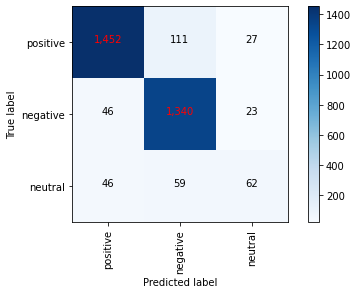

Save confusion-matrix...


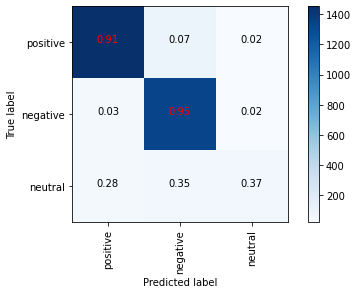

(0.901452937460518, 0.7938010516288317, 0.7451647102837592, 0.7630594828236843)

In [33]:
eval_model(model=model, data_reader=data_reader, test_df=test_df, plot_cm=True)

## Upsampling các ví dụ false

In [34]:
train_df_pred = predict_on_df(model=model, data_reader=data_reader, data_df=train_df, label_col='sentiment')
val_df_pred = predict_on_df(model=model, data_reader=data_reader, data_df=val_df, label_col='sentiment')

train_false_df = train_df_pred[train_df_pred['sentiment_pred'] != train_df_pred['sentiment']]
val_false_df = val_df_pred[val_df_pred['sentiment_pred'] != val_df_pred['sentiment']]

train_df_upsampling = pd.concat([train_df_upsampling, train_false_df, val_false_df])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model_up, data_reader_up = run_training_loop(
                        train_df=train_df_upsampling,
                        val_df=val_df,
                        label_col='sentiment',
                        serialization_dir='models',
                        checkpoint=False,
                        use_character=False,
                        bidirectional=True,
                        embedding_dim=100,
                        hidden_size=128,
                        char_embedding_dim=34,
                        dropout=0.4,
                        word_embedding_pretrain_file='/content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt',
                        num_epochs=20,
                        grad_clipping=5,
                        weight_decay=0.0001
                    )

num_epochs 10
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


  0%|          | 0/20577 [00:00<?, ?it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 138512.09it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.7717, recall: 0.8858, f1: 0.8248, accuracy: 0.8059, batch_loss: 0.2298, loss: 0.5069 ||: 100%|##########| 98/98 [00:02<00:00, 41.14it/s]
precision: 0.9071, recall: 0.9560, f1: 0.9309, accuracy: 0.9191, batch_loss: 0.2599, loss: 0.2570 ||: 100%|##########| 13/13 [00:00<00:00, 95.92it/s]
precision: 0.8741, recall: 0.9255, f1: 0.8991, accuracy: 0.8830, batch_loss: 0.2027, loss: 0.3170 ||: 100%|##########| 98/98 [00:02<00:00, 43.26it/s]
precision: 0.9161, recall: 0.9603, f1: 0.9377, accuracy: 0.9248, batch_loss: 0.1804, loss: 0.2041 ||: 100%|##########| 13/13 [00:00<00:00, 95.86it/s]
precision: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.9001895135818067
Precision: 0.806061502778447
Recall   : 0.7225127321674214
F1-Score : 0.7471586366099654
Save confusion-matrix...


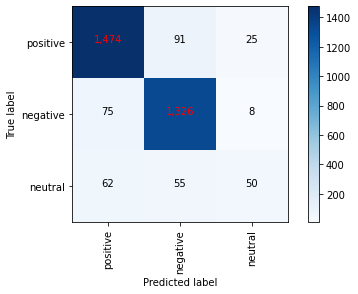

Save confusion-matrix...


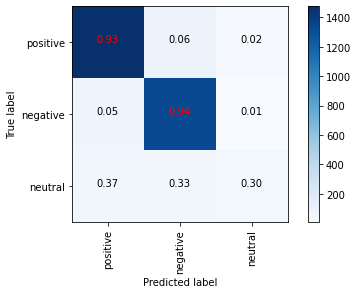

(0.9001895135818067, 0.806061502778447, 0.7225127321674214, 0.7471586366099654)

In [ ]:
eval_model(model=model_up, data_reader=data_reader_up, test_df=test_df, plot_cm=True)

# Train Kfold

In [ ]:
from sklearn.model_selection import KFold


train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
df = pd.concat([train_df, val_df])

neutral_df = df[df['sentiment'] == 'neutral']
df = pd.concat([df, neutral_df])
splits = list(KFold(n_splits=8, shuffle=True, random_state=42).split(df))

model_folds = []
for fold, (train_idx, val_idx) in enumerate(splits):
    print('-'*40 + str(fold) + '-'*40)
    train_df_ = df.iloc[train_idx.tolist()]
    val_df_ = df.iloc[val_idx.tolist()]
    model_folds.append(
        run_training_loop(
            train_df=train_df_,
            val_df=val_df_,
            label_col='sentiment',
            serialization_dir='models',
            checkpoint=False,
            use_character=True,
            bidirectional=True,
            embedding_dim=100,
            hidden_size=128,
            char_embedding_dim=34,
            dropout=0.4,
            word_embedding_pretrain_file='/content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt',
            num_epochs=5,
            grad_clipping=5,
            weight_decay=0.0001
        )
    )
    


----------------------------------------0----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:   8%|7         | 1077/13540 [00:00<00:01, 10719.08it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 94659.52it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.8135, recall: 0.8891, f1: 0.8496, accuracy: 0.8282, batch_loss: 0.2832, loss: 0.4534 ||: 100%|##########| 93/93 [00:06<00:00, 13.30it/s]
precision: 0.8661, recall: 0.9469, f1: 0.9047, accuracy: 0.8825, batch_loss: 1.3909, loss: 0.3916 ||: 100%|##########| 14/14 [00:00<00:00, 34.47it/s]
precision: 0.9015, recall: 0.9469, f1: 0.9237, accuracy: 0.9063, batch_loss: 0.1591, loss: 0.2605 ||: 100%|##########| 93/93 [00:07<00:00, 13.13it/s]
precision: 0.8848, recall: 0.9547, f1: 0.9184, accuracy: 0.9014, batch_loss: 1.2806, loss: 0.3549 ||: 100%|##########| 14/14 [00:00<00:00, 32.36it/s]
precision: 0.93

----------------------------------------1----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:   7%|7         | 967/13540 [00:00<00:01, 9665.49it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 109379.05it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.8168, recall: 0.8592, f1: 0.8374, accuracy: 0.8166, batch_loss: 0.2984, loss: 0.4650 ||: 100%|##########| 93/93 [00:07<00:00, 13.04it/s]
precision: 0.8671, recall: 0.9523, f1: 0.9077, accuracy: 0.8766, batch_loss: 1.4447, loss: 0.3941 ||: 100%|##########| 14/14 [00:00<00:00, 33.71it/s]
precision: 0.8976, recall: 0.9473, f1: 0.9218, accuracy: 0.9062, batch_loss: 0.3727, loss: 0.2663 ||: 100%|##########| 93/93 [00:07<00:00, 12.97it/s]
precision: 0.9038, recall: 0.9589, f1: 0.9305, accuracy: 0.9096, batch_loss: 0.9406, loss: 0.3179 ||: 100%|##########| 14/14 [00:00<00:00, 33.21it/s]
precision: 0.9362, recall: 0.9560, f1: 0.9460, accuracy: 0.9345, batch_loss: 0.0938, loss: 0.1963 ||: 100%|##########| 93/93 [00:07<00:00, 12.97it/s]
precision: 0.9111, recall: 0.9655, f1: 0.9375, accuracy: 0.9138, batch_loss: 0.6738, los

----------------------------------------2----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:   8%|7         | 1035/13540 [00:00<00:01, 10349.34it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 104985.66it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7926, recall: 0.8961, f1: 0.8412, accuracy: 0.8230, batch_loss: 0.3275, loss: 0.4706 ||: 100%|##########| 93/93 [00:06<00:00, 13.37it/s]
precision: 0.8766, recall: 0.9424, f1: 0.9083, accuracy: 0.8884, batch_loss: 1.3927, loss: 0.3675 ||: 100%|##########| 14/14 [00:00<00:00, 34.39it/s]
precision: 0.8997, recall: 0.9436, f1: 0.9211, accuracy: 0.9025, batch_loss: 0.1118, loss: 0.2705 ||: 100%|##########| 93/93 [00:06<00:00, 13.30it/s]
precision: 0.9026, recall: 0.9316, f1: 0.9169, accuracy: 0.8990, batch_loss: 1.0270, loss: 0.3106 ||: 100%|##########| 14/14 [00:00<00:00, 34.53it/s]
precision: 0.9323, recall: 0.9597, f1: 0.9458, accuracy: 0.9315, batch_loss: 0.1850, loss: 0.2051 ||: 100%|##########| 93/93 [00:07<00:00, 13.09it/s]
precision: 0.9199, recall: 0.9397, f1: 0.9297, accuracy: 0.9209, batch_loss: 0.9248, los

----------------------------------------3----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:   8%|7         | 1055/13540 [00:00<00:01, 10543.90it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 99059.85it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7984, recall: 0.9009, f1: 0.8465, accuracy: 0.8251, batch_loss: 0.3443, loss: 0.4720 ||: 100%|##########| 93/93 [00:07<00:00, 13.04it/s]
precision: 0.8833, recall: 0.9475, f1: 0.9143, accuracy: 0.8978, batch_loss: 1.4733, loss: 0.3526 ||: 100%|##########| 14/14 [00:00<00:00, 35.76it/s]
precision: 0.8959, recall: 0.9474, f1: 0.9209, accuracy: 0.9035, batch_loss: 0.2896, loss: 0.2731 ||: 100%|##########| 93/93 [00:07<00:00, 13.04it/s]
precision: 0.9178, recall: 0.9166, f1: 0.9172, accuracy: 0.9084, batch_loss: 1.0461, loss: 0.3072 ||: 100%|##########| 14/14 [00:00<00:00, 35.14it/s]
precision: 0.9328, recall: 0.9557, f1: 0.9441, accuracy: 0.9336, batch_loss: 0.1559, loss: 0.2025 ||: 100%|##########| 93/93 [00:07<00:00, 12.77it/s]
precision: 0.9137, recall: 0.9408, f1: 0.9271, accuracy: 0.9191, batch_loss: 1.2101, loss

## Evaluate KFold

In [ ]:
import numpy as np
def predict_kfold(model_folds, text: str):
    # print(text)
    tokens = [Token(token) for token in text.split(' ')]
    token_indexers = model_folds[0][1].token_indexers
    max_tokens = model_folds[0][1].max_tokens
    models = [x[0] for x in model_folds]
    vocab = model_folds[0][0].vocab

    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    text_field = TextField(tokens, token_indexers)
    instance = Instance({
        "tokens": text_field
    })
    outputs = [model.forward_on_instance(instance) for model in models]
    y_predictions = [np.argmax(output['probs'], axis=-1) for output in outputs]
    y_probs = [np.max(output['probs'], axis=-1) for output in outputs]
    predictions = [vocab.get_token_from_index(y_prediction, namespace='labels') for y_prediction in y_predictions]
    predictioin_final = max(predictions, key = predictions.count)
    return predictioin_final

In [ ]:
predict_kfold(model_folds, "nội dung môn học phù hợp, bắt đúng xu thế")

In [ ]:
vocab = model_folds[0][0].vocab

test_df = pd.read_csv(test_path)
texts = test_df['text'].tolist()
label_true = test_df['sentiment'].tolist()
label_pred = [predict_kfold(model_folds, text) for text in texts]
y_true = [vocab.get_token_index(label, namespace='labels') for label in label_true]
y_pred = [vocab.get_token_index(label, namespace='labels') for label in label_pred]

# get metric scores
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

labels = list(vocab.get_token_to_index_vocabulary('labels').keys())
report = classification_report(label_true, label_pred, labels=labels)
print(f'Evaluate ')
print('Accuracy :', acc)
print('Precision:', precision)
print('Recall   :', recall)
print('F1-Score :', f1)

In [ ]:
cm = confusion_matrix(label_true, label_pred, labels=labels)
plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix (sentiment)', normalize=False)
plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix Normalize (sentiment)', normalize=True)

In [ ]:
result_models = []
for model, data_reader in model_folds:
    print('-'*80)
    result = eval_model(model, data_reader, test_df)
    result_models.append(result)

In [ ]:
f1s = [x[-1] for x in result_models]
best_model_index = np.argmax(f1s)
print(result_models[best_model_index])
# print(model_folds[best_model_index][0])

In [ ]:
serialization_dir = '/content/drive/MyDrive/Learning/20202/NLP/best_model_kfold_1up_char'

best_model = model_folds[best_model_index][0]
best_model.vocab.save_to_files(serialization_dir + '/vocabulary')
torch.save(best_model.state_dict(), serialization_dir + '/best.th')

In [ ]:
print(best_model)

## eval best model

In [ ]:
from allennlp.training.util import evaluate
dataset_reader = model_folds[best_model_index][1]
test_data = list(dataset_reader.read(test_df))
data_loader = SimpleDataLoader(test_data, batch_size=64)
data_loader.index_with(best_model.vocab)

results = evaluate(best_model.to('cpu'), data_loader)
print(results)

In [ ]:
eval_model(best_model, dataset_reader, test_df, plot_cm=True)

In [ ]:
test_df = predict_on_df(model=best_model, data_reader=dataset_reader, data_df=test_df,label_col='sentiment')
test_df_false = test_df[test_df['sentiment'] != test_df['sentiment_pred']]
test_df_true = test_df[test_df['sentiment'] == test_df['sentiment_pred']]


In [ ]:
test_df_false.to_csv('/content/drive/MyDrive/Learning/20202/NLP/false_sent_pred.csv', index=False)
test_df_true.to_csv('/content/drive/MyDrive/Learning/20202/NLP/true_sent_pred.csv', index=False)